In [103]:
import pandas as pd
import numpy as np

import sympy
from sympy import ordered, Matrix, hessian, Trace
from sympy.vector import laplacian, divergence, gradient, curl, CoordSys3D, Del
from sympy.plotting import plot3d 

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
plotly.offline.init_notebook_mode()


Index(['Node Number', 'X Location (mm)', 'Y Location (mm)', 'Z Location (mm)',
       'Total Deformation (mm)'],
      dtype='object')


Text(0, 0.5, 'Deformation: H(x,y)')

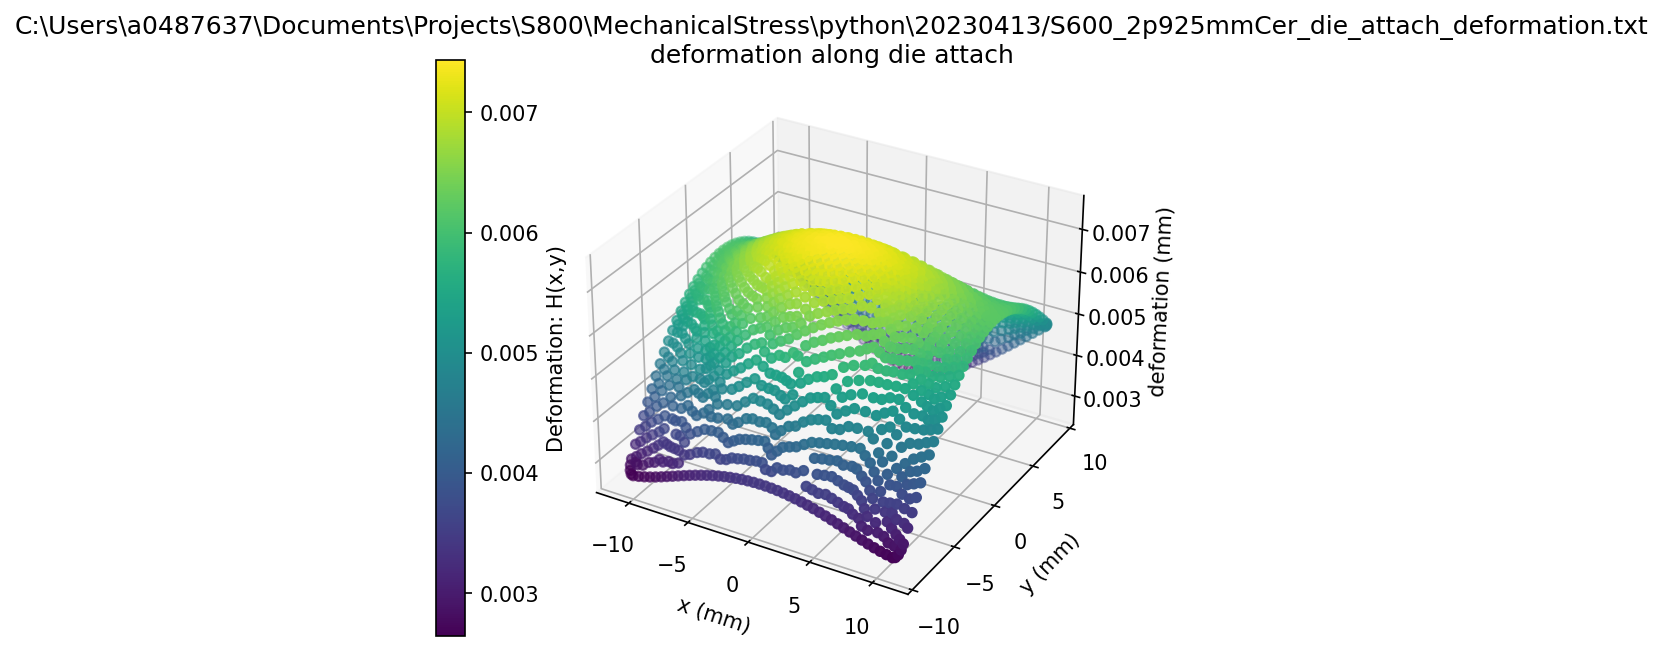

In [104]:
## Open Tab-seperated file with lsit of X,Y,z positions of data

folder = "C:\\Users\\a0487637\\Documents\\Projects\\S800\\MechanicalStress\\python\\20230413"
filename = f"{folder}/S600_2p925mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S600_3p785mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_2p925mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_3p2mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_3p5mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_3p785mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_3p8mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_3p9mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_4p0mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_4p1mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800_4p2mmCer_die_attach_deformation.txt"

folder = "20230426_S800C"
# filename = f"{folder}/S800C_4p2mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_4p1mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_4p0mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_3p9mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_3p8mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_3p785mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_3p5mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_3p2mmCer_die_attach_deformation.txt"
# filename = f"{folder}/S800C_2p925mmCer_die_attach_deformation.txt"

C_NODE = "Node Number"
C_X = "X Location (mm)"
C_Y = "Y Location (mm)"
C_Z = "Z Location (mm)"
C_DEF = "Total Deformation (mm)"

df = pd.read_csv(filename, sep="\t")
cols = df.columns
print(cols)
df

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
# ax = plt.axes(projection='3d')
pcm = ax.scatter(df[C_X], df[C_Y], df[C_DEF], c=df[C_DEF], cmap='viridis')

ax.ticklabel_format(style='plain', axis='z', scilimits=(0, 0))
ax.set_title(f'{filename}\ndeformation along die attach')
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel('deformation (mm)')
# ax.view_init(30, -145)

cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Deformation: H(x,y)")

In [105]:
fig = go.Figure(data=[go.Scatter3d(x=df[C_X], y=df[C_Y], z=df[C_DEF],
    mode='markers', 
    marker=dict(
        size=1,
        color=df[C_DEF],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        colorbar=dict(orientation='v'),
        opacity=0.8
    ))])
    
fig.update_layout(title=f'{filename}\ndeformation along die attach', autosize=False, width=500, height=500, margin=dict(l=0, r=0, b=0), coloraxis_showscale=True)
fig.show()

Range = Min: (-11.16,-9.16)  Max: (11.16,9.16)
Note: Matrix forms have flipped y axis (upside-down)


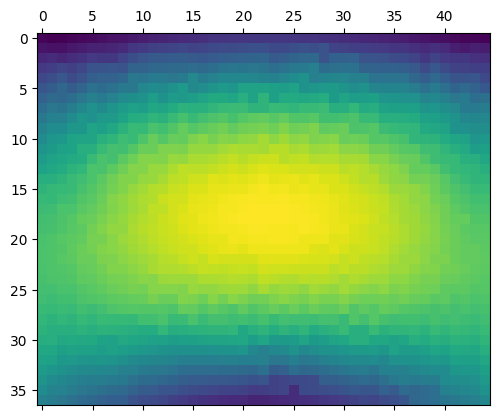

In [106]:
# Find bounding box of data
x_min = df.iloc[0][C_X]
y_min = df.iloc[0][C_Y]
x_max = df.iloc[0][C_X]
y_max = df.iloc[0][C_Y]
for index, row in df.iterrows():
    # print(row[C_X], row[C_Y])
    x = float(row[C_X])
    y = float(row[C_Y])
    if y > y_max:
        y_max = y
    if x > x_max:
        x_max = x
    if y < y_min:
        y_min = y
    if x < x_min:
        x_min = x

print(f"Range = Min: ({x_min},{y_min})  Max: ({x_max},{y_max})")

resolution = 0.5
x_steps = np.arange(x_min, x_max, resolution)
y_steps = np.arange(y_min, y_max, resolution)
nx = len(x_steps)
ny = len(y_steps)

data = []
for p_x in x_steps:
    for p_y in y_steps:
        df_closest = (
            df.copy(deep=True)
            .assign(d=(p_x - df[C_X]) ** 2 + (p_y - df[C_Y]) ** 2)
            .sort_values("d")
            .drop("d", axis=1)
        )
        # biased average
        # sum_dist = sum([(p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 for i in range(0,2)])
        # avg = (
        #     sum([df_closest.iloc[i][C_DEF] * ( (p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 )/sum_dist for i in range (0,2)])
        #     # / sum_dist
        # )
        # data.append({C_X: p_x, C_Y: p_y, C_DEF: avg})
        data.append({C_X: p_x, C_Y: p_y, C_DEF: df_closest.iloc[0][C_DEF]})

df_ortho = pd.DataFrame(data)

Z = np.empty((len(y_steps),0))
for x_pos in x_steps:
    col = []
    for y_pos in y_steps:
        df_val = df_ortho.loc[(df_ortho[C_X] == x_pos) & (df_ortho[C_Y] == y_pos)]
        col.append(df_val[C_DEF])
    npcol = np.vstack(col)
    Z = np.append(Z,npcol,1)

print("Note: Matrix forms have flipped y axis (upside-down)")
plt.matshow(Z)


In [107]:
## Generated Z test data

# fstr = "x**2+y**2"
# x_min =-5
# x_max=5
# y_min=-5
# y_max=5
# resolution = 0.5
# x_steps = np.arange(x_min, x_max, resolution)
# y_steps = np.arange(y_min, y_max, resolution)
# nx = len(x_steps)
# ny = len(y_steps)
# f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
# print(f)
# v = list(ordered(f.free_symbols)); v

# x = np.linspace(x_min, x_max, nx)
# y = np.linspace(y_min, y_max, ny)

# Z = np.empty(shape=(ny, nx))

# for i in range(len(x)):
#     for j in range(len(y)):
#         Z[j, i] = f.subs({v[0]: x[i], v[1]: y[j]})

# np.random.seed(42)
# noise_sigma = 0.001
# Z += noise_sigma * np.random.randn(*Z.shape)
# plt.matshow(Z)

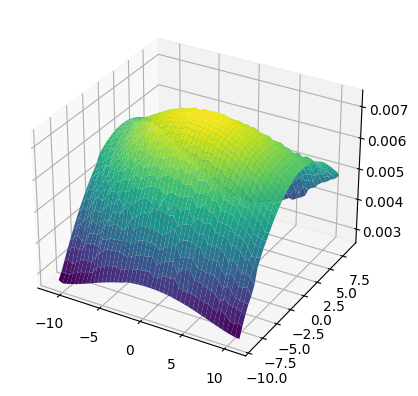

In [108]:
X, Y = np.meshgrid(x_steps, y_steps)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

In [109]:
fig = go.Figure(go.Surface(x=X, y=Y, z=Z))
fig.update_traces(contours_z=dict(show=True, usecolormap=True, project_z=True, width=10, start=0, end=0.03, size=0.001))
fig.update_layout(title='', autosize=False, width=500, height=500, margin=dict(l=0, r=0, b=0), coloraxis_showscale=True)
fig.show()

The polynomial regression model: 1, x, x^2, ..., xy, x^2y, ... etc.

$$
z_i \,=\, c_0 + c_1 x_i + c_2 x_i^2 + \cdots + c_{i} y_{i} + c_{i} x_{i} y_{i} + c_i x_i^2 y_i + \cdots + c_m x_i^m y_i^m + \varepsilon_i\  (i = 1, 2, \dots , n) 
$$

can be expressed in matrix form in terms of a design matrix $\mathbf{A}$, a response vector $\vec y$, a parameter vector $\vec c$, and a vector $\vec\varepsilon$ of random errors. The ''i''-th row of $\mathbf{A}$ and $\vec y$ will contain the ''x'' and ''y'' value for the ''i''-th data sample. Then the model can be written as a system of linear equations:

$$
 \begin{bmatrix} z_1\\ z_2\\ z_3 \\ \vdots \\ z_n \end{bmatrix}= \begin{bmatrix} 1 & x_1 & x_1^2 & \dots & x_1^m y_1^m \\ 1 & x_2 & x_2^2 &  \dots & x_2^m y_2^m \\ 1 & x_3 & x_3^2 & \dots & x_3^m y_3^m \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & x_n^2 & \dots & x_n^m y_n^m \end{bmatrix} \begin{bmatrix} c_0\\ c_1\\ c_2\\ \vdots \\ c_{m^2} \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \varepsilon_3 \\ \vdots \\ \varepsilon_n \end{bmatrix}, 
$$

which when using pure matrix notation is written as

$$
\vec z = \mathbf{A} \vec c + \vec\varepsilon
$$

f(x,y) = 0.0074309364675612406 * x**0 * y**0 + 5.47357899196928e-06 * x**1 * y**0 + -1.3343667748093953e-05 * x**2 * y**0 + -2.2145099553893485e-09 * x**3 * y**0 + 1.138031730306762e-08 * x**4 * y**0 + -3.8934937682835766e-05 * x**0 * y**1 + -5.0974652508101104e-08 * x**1 * y**1 + 1.2467614091890012e-06 * x**2 * y**1 + 2.6466497067191282e-09 * x**3 * y**1 + -5.533383835000518e-05 * x**0 * y**2 + -2.289366491156733e-09 * x**1 * y**2 + 2.0711187146273883e-07 * x**2 * y**2 + 1.8308947323919917e-07 * x**0 * y**3 + 2.871618723015514e-09 * x**1 * y**3 + 4.5370182034072814e-08 * x**0 * y**4
RMS residual = 7.405662300819036e-05


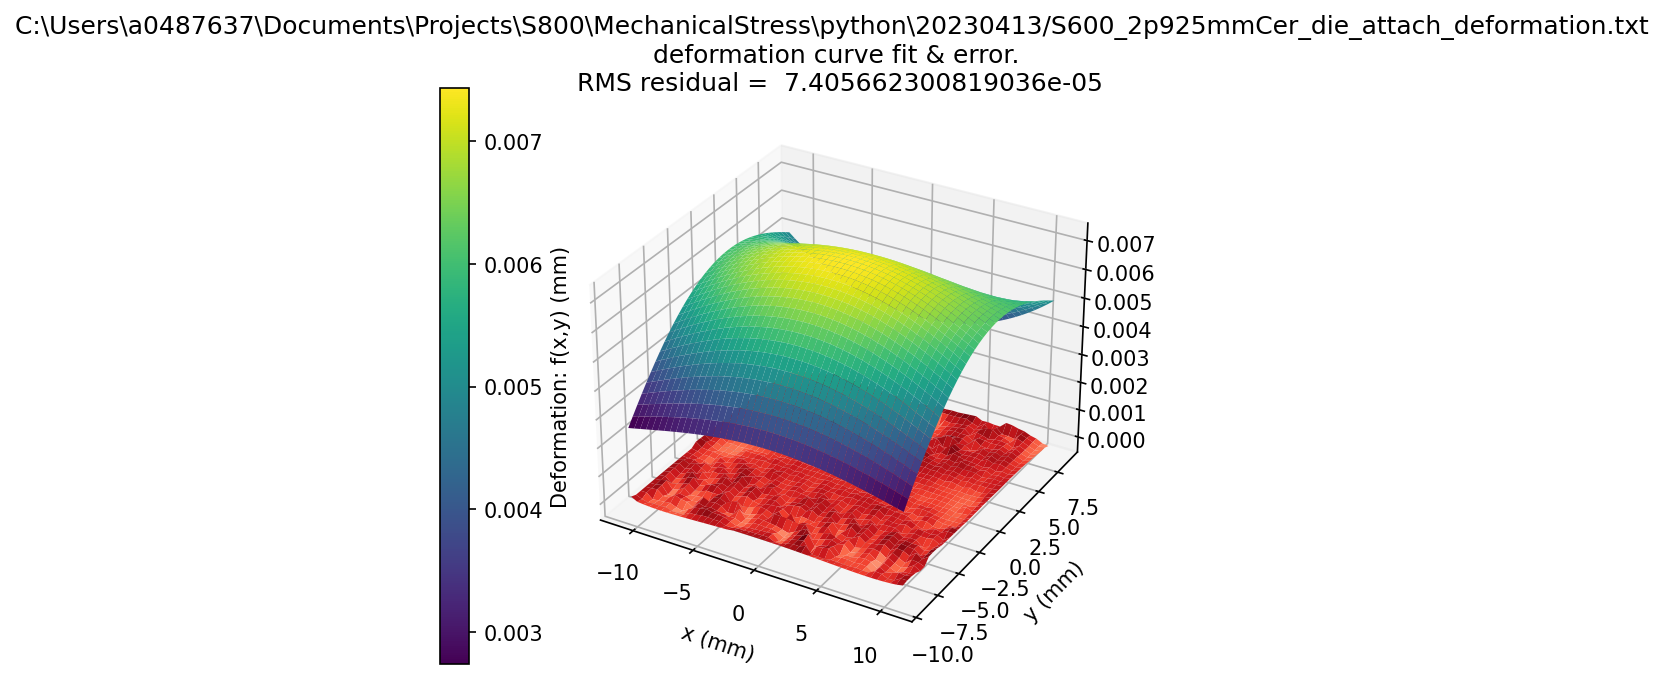

In [110]:
# https://scipython.com/blog/linear-least-squares-fitting-of-a-two-dimensional-data/


def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

def get_basis_str(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis_str = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis_str.append(f'x**{j} * y**{i}')
    return basis_str

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 4
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()

# https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)
# c is our basis coefficients

basis_str = get_basis_str(x, y, max_order)
fstr = ' + '.join([f'{c[i]} * {basis_str[i]}' for i in range(len(c))])
print("f(x,y) =", fstr)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n deformation curve fit & error. \n RMS residual =  {rms}')
pcm = ax.plot_surface(X, Y, fit, cmap='viridis')
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Deformation: f(x,y) (mm)")
pcm = ax.plot_surface(X, Y, Z-fit, cmap='Reds')
# Add Labels

In [111]:
## 2D Gaussian Distribution Test
# fstr = "(1/(2*pi*1**2))*exp(-(x**2+y**2)/(2*1**2))"
# fstr = "-0.012233051892616125 * x**0 * y**0 + -0.000329373619938677 * x**1 * y**0 + 3.3782558542436995e-05 * x**2 * y**0 + -1.0023939893806668e-06 * x**3 * y**0 + 9.16128937360032e-09 * x**4 * y**0 + 0.002709676092513422 * x**0 * y**1 + 0.00011714893909836583 * x**1 * y**1 + -2.437628856953166e-06 * x**2 * y**1 + 2.283316500554123e-09 * x**3 * y**1 + -8.241336609688418e-05 * x**0 * y**2 + -3.7136880079460383e-06 * x**1 * y**2 + 7.363885255969092e-08 * x**2 * y**2 + 1.580578402319046e-06 * x**0 * y**3 + -7.13177359277172e-10 * x**1 * y**3 + -1.5600859255057026e-08 * x**0 * y**4"
# x_min =5
# x_max=45
# y_min=12
# y_max=36
# resolution = 0.5
# x_steps = np.arange(x_min, x_max, resolution)
# y_steps = np.arange(y_min, y_max, resolution)
# nx = len(x_steps)
# ny = len(y_steps)

In [112]:
f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
f

1.138031730306762e-8*x**4*y**0 + 2.6466497067191282e-9*x**3*y**1 - 2.2145099553893485e-9*x**3*y**0 + 2.0711187146273883e-7*x**2*y**2 + 1.2467614091890012e-6*x**2*y**1 - 1.3343667748093953e-5*x**2*y**0 + 2.871618723015514e-9*x**1*y**3 - 2.289366491156733e-9*x**1*y**2 - 5.0974652508101104e-8*x**1*y**1 + 5.47357899196928e-6*x**1*y**0 + 4.5370182034072814e-8*x**0*y**4 + 1.8308947323919917e-7*x**0*y**3 - 5.533383835000518e-5*x**0*y**2 - 3.8934937682835766e-5*x**0*y**1 + 0.0074309364675612406*x**0*y**0

In [113]:
# get our variables
v = list(ordered(f.free_symbols)); v

[x, y]

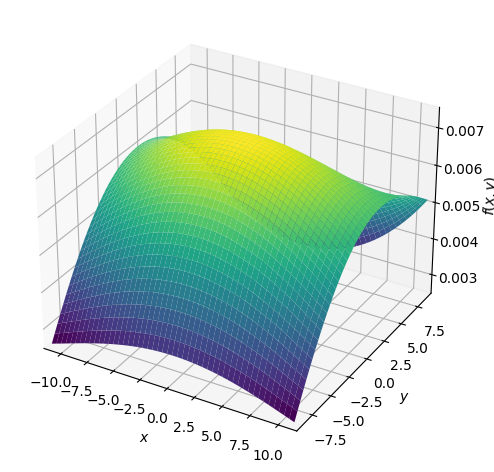

In [114]:
pcm = plot3d(f, (v[0], x_min, x_max), (v[1], y_min, y_max))

The '''mean curvature''' at $p\in S$ is then the average of the signed curvature over all angles $\theta$:
$$
H = \frac{1}{2\pi}\int_0^{2\pi} \kappa(\theta) \;d\theta
$$

By applying [[Euler's theorem (differential geometry)|Euler's theorem]], this is equal to the average of the principal curvatures {{harv|Spivak|1999|loc=Volume 3, Chapter 2}}:
$$
H = {1 \over 2} (\kappa_1 + \kappa_2)
$$

For the special case of a surface defined as a function of two coordinates, e.g. $z = S(x, y)$, and using the upward pointing normal the mean curvature expression is

$$
H = \frac{1}{2}
\frac{
\left(1 + \left(\frac{\partial S}{\partial x}\right)^2\right) \frac{\partial^2 S}{\partial y^2} - 
2 \frac{\partial S}{\partial x} \frac{\partial S}{\partial y} \frac{\partial^2 S}{\partial x \partial y} + 
\left(1 + \left(\frac{\partial S}{\partial y}\right)^2\right) \frac{\partial^2 S}{\partial x^2}
}{\left(1 + \left(\frac{\partial S}{\partial x}\right)^2 + \left(\frac{\partial S}{\partial y}\right)^2\right)^{3/2}}
$$


Gaussian curvature is defined as

$$
K = \kappa_1 \kappa_2
$$

Similarly, for a surface described as graph of a function $z = S(x, y)$, Gaussian curvature is:

<!-- $$
K = \frac{F_{xx}\cdot F_{yy}- F_{xy}^2}{\left(1+F_x^2+ F_y^2\right)^2}
$$ -->

$$
K = \frac{\frac{\partial^2 S}{\partial x^2} \cdot \frac{\partial^2 S}{\partial y^2} - \left( \frac{\partial^2 S}{\partial x \partial y} \right)^2}
{\left( 1 + \left( \frac{\partial S}{\partial x} \right)^2 + \left( \frac{\partial S}{\partial x} \right)^2 \right)^2}
$$

Principal curvature, $\kappa$ , can be the defined as

$$
\kappa_1 = H + \sqrt{H^2 - K}
$$
$$
\kappa_2 = H - \sqrt{H^2 - K}
$$

With $\kappa_1$ represnting the maximum and $\kappa_2$ beign the minimum

Knowing $\kappa$ , the equation for radius of curvature is 
$$
% \kappa = \frac{1}{r}
r= \frac{1}{\kappa }
$$

Let {{mvar|S}} be a regular surface in {{math|ℝ<sup>3</sup>}}. Given a local parametrization {{math|''f'' : ''V'' → ''S''}} and a unit normal vector field {{mvar|n}} to {{math|''f''(''V'')}}, one defines the following objects as real-valued or matrix-valued functions on {{mvar|V}}. The first fundamental form depends only on {{mvar|f}}, and not on {{mvar|n}}. The fourth column records the way in which these functions depend on {{mvar|f}}, by relating the functions {{math|''E'' ′, ''F'' ′, ''G'' ′, ''L'' ′, }} etc., arising for a different choice of local parametrization, $f′ : V′  → S$, to those arising for {{mvar|f}}. Here {{mvar|A}} denotes the [[Jacobian matrix and determinant|Jacobian matrix]] of {{math|''f''<sup> –1</sup> ∘ ''f'' ′}}. The key relation in establishing the formulas of the fourth column is then
:$\begin{pmatrix}\frac{\partial f'}{\partial u}\\ \frac{\partial f'}{\partial v}\end{pmatrix}=A\begin{pmatrix}\frac{\partial f}{\partial u}\\ \frac{\partial f}{\partial v}\end{pmatrix},$
as follows by the [[chain rule]].

| Terminology                 | Notation                      | Definition                                                                     | Dependence on local parametrization                                            |
|-----------------------------|-------------------------------|--------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| First fundamental form      | $E$                           | $E=\frac{\partial f}{\partial u}\cdot\frac{\partial f}{\partial u}$ | $\begin{pmatrix}E'&F'\\ F'&G'\end{pmatrix}=A\begin{pmatrix}E&F\\ F&G\end{pmatrix}A^T$ |
|                             | $F$                           | $F=\frac{\partial f}{\partial u}\cdot\frac{\partial f}{\partial v}$ |
|                             | $G$                           | $G=\frac{\partial f}{\partial v}\cdot\frac{\partial f}{\partial v}$ |
| Second fundamental form     | $L$                           | $L=\frac{\partial^2 f}{\partial u^2}\cdot n$                        | $\begin{pmatrix}L'&M'\\ M'&N'\end{pmatrix}=A\begin{pmatrix}L&M\\ M&N\end{pmatrix}A^T$ |
|                             | $M$                           | $M=\frac{\partial^2f}{\partial u\partial v}\cdot n$                 |
|                             | $N$                           | $N=\frac{\partial^2f}{\partial v^2}\cdot n$                         |
| Shape operator              | $P$                           | $P=\begin{pmatrix}L&M\\ M&N\end{pmatrix}\begin{pmatrix}E&F\\ F&G\end{pmatrix}^{-1}$ | $P'=APA^{-1}$ |
| Gaussian curvature          | $K$                           | $K=\frac{LN-M^2}{EG-F^2}$                                           | $K'=K$                                                                                |
| Mean curvature              | $H$                           | $H=\frac{GL-2FM+EN}{2(EG-F^2)}$                                     | $H'=H$                                                                                |
| Principal curvatures        | $\kappa_\pm$       | $H\pm\sqrt{H^2-K}$                                                  | $\kappa_{\pm}'=\kappa_\pm$                                          |



The following summarizes the calculation of the above quantities relative to a Monge patch $f(u, v) = (u, v, h(u, v))$. Here $h_u$ and $h_v$ denote the two partial derivatives of $h$, with analogous notation for the second partial derivatives. The second fundamental form and all subsequent quantities are calculated relative to the given choice of unit normal vector field.

| Quantity                   | Formula                                                                                                                                                                                         |
|----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| A unit normal vector field | $n=\frac{(-h_u,-h_v,1)}{\sqrt{1+h_u^2+h_v^2}}$                                                                                                                                       |
| First fundamental form     | $\begin{pmatrix}E&F\\ F&G\end{pmatrix}=\begin{pmatrix} 1 +h_u^2 & h_u h_v \\ h_u h_v & 1 + h_v^2\end{pmatrix}$                                                                       |
| Second fundamental form    | $\begin{pmatrix}L&M\\ M&N\end{pmatrix}=\frac{1}{\sqrt{1 +h_u^2 + h_v^2}} \begin{pmatrix} h_{uu} & h_{uv} \\ h_{uv} & h_{vv} \end{pmatrix}$                                           |
| Shape operator             | $P=\frac{1}{(1+h_u^2+h_v^2)^{3/2}}\begin{pmatrix}h_{uu}(1+h_v^2)-h_{uv}h_uh_v&h_{uv}(1+h_u^2)-h_{uu}h_uh_v\\ h_{uv}(1+h_v^2)-h_{vv}h_uh_v&h_{vv}(1+h_u^2)-h_{uv}h_uh_v\end{pmatrix}$ |
| Gaussian curvature         | $K=\frac{h_{uu}h_{vv}-h_{uv}^2}{(1+h_u^2+h_v^2)^2}$                                                                                                                                  |
| Mean curvature             | $H=\frac{(1+h_v^2)h_{uu}-2h_uh_vh_{uv}+(1+h_u^2)h_{vv}}{2(1+h_u^2+h_v^2)^{3/2}}$                                                                                                     |


If $p∈M$, then for each tangent vector $v$ to $M$ at $p$, define the shape operator:

$$
S_p(v) = - \nabla_v U
$$
Where $U$ is a normal vector field to $M$ defined in a neighborhood of $p$.

We can also talk about principal curvature in terms of the shape operator, which is the unique map $S: TM \rarr TM$
 satisfying

$$
df(SX) = dN(X)
$$

for all tangent vectors $X$. The shape operator $S$ and the Weingarten map $dN$ essentially represent the same idea: they both tell us how the normal changes as we travel along a direction $X$. The only difference is that $S$ specifies this 
change in terms of a tangent vector on $M$, whereas $dN$ gives us the change as a tangent vector in $\mathbb{R}^3$.

By a direct calculation with the matrix defining the shape operator, it can be checked that the Gaussian curvature is the determinant of the shape operator, the mean curvature is half of the trace of the shape operator, and the principal curvatures are the eigenvalues of the shape operator with their directions being the corresponding eigenvectors; moreover the Gaussian curvature is the product of the principal curvatures and the mean curvature is their sum.

In [115]:
def gradient(f: sympy.Function, vars: list[sympy.Symbol]) -> sympy.Matrix:
    return sympy.Matrix([f]).jacobian(sympy.Matrix(vars))

def curvature_explicit(
    h: sympy.Function, vars: tuple[sympy.Symbol], point: tuple = None
):
    """
    h is an sympy expression of explicit definition: h(u, v) = z
    alternatively though of as a monge patch (u, v) ↦ (u, v, h(u, v))
    vars is list or tuple of sympy symbols: (u, v)
    point is a tuple of (u, v) values to evaluate the curvature at
    """
    # https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces

    u, v = vars

    h_u = sympy.diff(h, u)
    h_v = sympy.diff(h, v)
    h_uu = sympy.diff(h_u, u)
    h_uv = sympy.diff(h_u, v)
    # h_vu = sympy.diff(h_v, u)
    h_vv = sympy.diff(h_v, v)

    ## alternatively
    # h_u, h_v = gradient(h, vars)
    # h_uu, h_uv = gradient(f_u, vars)
    # h_vu, h_vv = gradient(f_v, vars)

    # Shape operator
    P = sympy.Matrix(
        [
            [
                h_uu * (1 + h_v**2 - h_uv * h_u * h_v),
                h_uv * (1 + h_u**2 - h_uu * h_u * h_v),
            ],
            [
                h_uv * (1 + h_v**2 - h_vv * h_u * h_v),
                h_vv * (1 + h_u**2 - h_uv * h_u * h_v),
            ],
        ]
    ) / ((1 + h_u**2 + h_v**2) ** (3 / 2))
    # Gaussian curvature
    K = (h_uu * h_vv - h_uv**2) / ((1 + h_u**2 + h_v**2) ** 2)
    # Mean curvature
    H = (
        ((1 + h_u**2) * h_vv - 2 * h_u * h_v * h_uv + (1 + h_v**2) * h_uu)
        / ((1 + h_u**2 + h_v**2) ** (3 / 2))
    ) / 2

    if point is None:
        X = P.eigenvects()
    else:
        X = P.subs({u: point[0], v: point[1]}).eigenvects()
        K = K.subs({u: point[0], v: point[1]})
        H = H.subs({u: point[0], v: point[1]})

    k1 = X[0][0]
    k2 = X[1][0]
    X1 = X[0][2][0]
    X2 = X[1][2][0]

    dh = gradient(sympy.Matrix([u, v, h]), vars)
    if point is None:
        k1vec = dh * X1
        k2vec = dh * X2
    else:
        k1vec = (dh * X1).subs({u: point[0], v: point[1]})
        k2vec = (dh * X2).subs({u: point[0], v: point[1]})

    ## alternatively
    # k1 = H + sympy.sqrt(H**2 - K)
    # k2 = H - sympy.sqrt(H**2 - K)

    return K, H, k1, k2, k1vec, k2vec


def curvature_discrete_parametric(X: np.array, Y: np.array, Z: np.array):
    # known by MATLAB as surfature
    # where X, Y, Z matrices have a shape (lr+1,lb+1)
    # https://github.com/sujithTSR/surface-curvature/blob/master/surface.py

    (lr, lb) = X.shape

    # First Derivatives
    Xv, Xu = np.gradient(X)
    Yv, Yu = np.gradient(Y)
    Zv, Zu = np.gradient(Z)

    # Second Derivatives
    Xuv, Xuu = np.gradient(Xu)
    Yuv, Yuu = np.gradient(Yu)
    Zuv, Zuu = np.gradient(Zu)

    Xvv, Xuv = np.gradient(Xv)
    Yvv, Yuv = np.gradient(Yv)
    Zvv, Zuv = np.gradient(Zv)

    # Reshape to 1D vectors (same as ravel?)
    Xu = np.reshape(Xu, lr * lb)
    Yu = np.reshape(Yu, lr * lb)
    Zu = np.reshape(Zu, lr * lb)
    Xv = np.reshape(Xv, lr * lb)
    Yv = np.reshape(Yv, lr * lb)
    Zv = np.reshape(Zv, lr * lb)
    Xuu = np.reshape(Xuu, lr * lb)
    Yuu = np.reshape(Yuu, lr * lb)
    Zuu = np.reshape(Zuu, lr * lb)
    Xuv = np.reshape(Xuv, lr * lb)
    Yuv = np.reshape(Yuv, lr * lb)
    Zuv = np.reshape(Zuv, lr * lb)
    Xvv = np.reshape(Xvv, lr * lb)
    Yvv = np.reshape(Yvv, lr * lb)
    Zvv = np.reshape(Zvv, lr * lb)

    Xu = np.c_[Xu, Yu, Zu]
    Xv = np.c_[Xv, Yv, Zv]
    Xuu = np.c_[Xuu, Yuu, Zuu]
    Xuv = np.c_[Xuv, Yuv, Zuv]
    Xvv = np.c_[Xvv, Yvv, Zvv]

    # % First fundamental Coefficients of the surface (E,F,G)
    E = np.einsum("ij,ij->i", Xu, Xu)
    F = np.einsum("ij,ij->i", Xu, Xv)
    G = np.einsum("ij,ij->i", Xv, Xv)

    m = np.cross(Xu, Xv, axisa=1, axisb=1)
    p = np.sqrt(np.einsum("ij,ij->i", m, m))
    n = m / np.c_[p, p, p]

    # % Second fundamental Coefficients of the surface (L,M,N)
    L = np.einsum("ij,ij->i", Xuu, n)
    M = np.einsum("ij,ij->i", Xuv, n)
    N = np.einsum("ij,ij->i", Xvv, n)

    # % Gaussian Curvature
    K = (L * N - M**2) / (E * G - F**2)

    # % Mean Curvature
    H = (E * N + G * L - 2 * F * M) / (2 * (E * G - F**2))

    # % Shape Operator as 3D a matrix of 2D matrices (2, 2, lr*lb)
    LMMN = np.array([[L, M], [M, N]])
    EFFG = np.array([[E, F], [F, G]])
    # reshape so that the 2D matrices are in the last dimension (lr*lb, 2, 2)
    LMMN = np.swapaxes(LMMN, 0, 2)
    EFFG = np.swapaxes(EFFG, 0, 2)

    P = LMMN * np.linalg.inv(EFFG)
    X = np.linalg.eig(P)

    # the result of eig is a tuple of (eigenvalues, eigenvectors)
    k1 = X[0][:, 0]  # all the first eigenvalues
    k2 = X[0][:, 1]  # all the second eigenvalues
    X1 = X[1][:, 0, :]  # all the first eigenvectors
    X2 = X[1][:, 1, :]  # all the second eigenvectors

    X1 = np.expand_dims(X1, 2)  # add a dimension to the end (lr*lb, 3, 1)
    X2 = np.expand_dims(X2, 2)  # add a dimension to the end (lr*lb, 3, 1)

    dX = np.dstack((Xu, Xv))

    # matrix multiplication of dX and X1 for each point
    k1vec = np.einsum("ijk,ikl->ilj", dX, X1)
    k2vec = np.einsum("ijk,ikl->ilj", dX, X2)

    # normalize the vectors
    k1vec = k1vec / np.linalg.norm(k1vec, axis=2, keepdims=True)
    k2vec = k2vec / np.linalg.norm(k2vec, axis=2, keepdims=True)

    # #% Principal Curvatures k1, k2 (alternative from gaussian and mean curvature)
    # k1 = H + np.sqrt(H**2 - K)
    # k2 = H - np.sqrt(H**2 - K)

    # reshape back to 2D x,y matrices
    K = np.reshape(K, (lr, lb))
    H = np.reshape(H, (lr, lb))
    k1 = np.reshape(k1, (lr, lb))
    k2 = np.reshape(k2, (lr, lb))
    k1vec = np.reshape(k1vec, (lr, lb, 3))
    k2vec = np.reshape(k2vec, (lr, lb, 3))

    return K, H, k1, k2, k1vec, k2vec


# TODO: DiffGeoOps off mesh

https://math.stackexchange.com/questions/1985889/why-how-does-the-determinant-of-the-hessian-matrix-combined-with-the-2nd-deriva 

((1.224733466617802e-8*(2.3915291127810226e-5*x**3 + 0.0037429514676478148*x**2*y + 0.01126581352718399*x**2 + 7.784437539426302e-5*x*y**2 - 4.137371560374536e-5*x*y - 0.00046061012599260911*x + 0.0016398711308292448*y**3 + 0.0049632235544847766*y**2 - y - 0.35181851506992123)**2 + 1)*(1.365638076368114e-7*x**2 + 1.5879898240314769e-8*x*y - 1.3287059732336091e-8*x + 4.1422374292547766e-7*y**2 + 2.4935228183780024e-6*y - 2.6687335496187906e-5) + (7.1221387588609099e-10*(0.0017057255198359112*x**3 + 0.00029751749181897718*x**2*y - 0.00024893942173871296*x**2 + 0.015521360046777489*x*y**2 + 0.093434686229136071*x*y - x + 0.00010760230160203532*y**3 - 8.5784753276839965e-5*y**2 - 0.0019100690106504813*y + 0.20510024287554453)**2 + 1)*(4.1422374292547766e-7*x**2 + 1.722971233809308e-8*x*y - 4.578732982313466e-9*x + 5.4444218440887377e-7*y**2 + 1.098536839435195e-6*y - 0.0001106676767000104) - (7.9399491201573846e-9*x**2 + 8.2844748585095532e-7*x*y + 2.4935228183780024e-6*x + 8.6148561690465

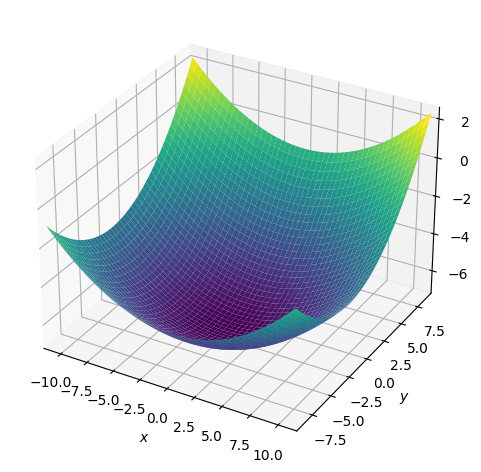

In [116]:
import surface_curvature
x, y = sympy.symbols("x y")
H = surface_curvature.symbolic.mean_curvature_explicit(f, (x,y))
display(H)
plot3d(H, (v[0], x_min, x_max), (v[1], y_min, y_max))

((1.365638076368114e-7*x**2 + 1.5879898240314769e-8*x*y - 1.3287059732336091e-8*x + 4.1422374292547766e-7*y**2 + 2.4935228183780024e-6*y - 2.6687335496187906e-5)*(4.1422374292547766e-7*x**2 + 1.722971233809308e-8*x*y - 4.578732982313466e-9*x + 5.4444218440887377e-7*y**2 + 1.098536839435195e-6*y - 0.0001106676767000104) - 6.2176560457717764e-12*(0.0031842295813928815*x**2 + 0.33223978531299243*x*y + x + 0.0034548936570993047*y**2 - 0.0018362506846004562*y - 0.020442825761369739)**2)/(1.224733466617802e-8*(2.3915291127810226e-5*x**3 + 0.0037429514676478148*x**2*y + 0.01126581352718399*x**2 + 7.784437539426302e-5*x*y**2 - 4.137371560374536e-5*x*y - 0.00046061012599260911*x + 0.0016398711308292448*y**3 + 0.0049632235544847766*y**2 - y - 0.35181851506992123)**2 + 7.1221387588609099e-10*(0.0017057255198359112*x**3 + 0.00029751749181897718*x**2*y - 0.00024893942173871296*x**2 + 0.015521360046777489*x*y**2 + 0.093434686229136071*x*y - x + 0.00010760230160203532*y**3 - 8.5784753276839965e-5*y**

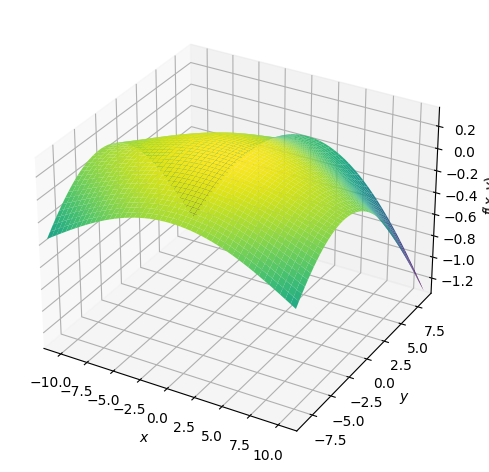

In [117]:
K = surface_curvature.symbolic.gaussian_curvature_explicit(f, (x,y))
display(K)
plot3d(K, (v[0], x_min, x_max), (v[1], y_min, y_max))

In [118]:
K, H, k1, k2, k1vec, k2vec = surface_curvature.symbolic.curvature_explicit(f, (x,y), (0,0))

display(K)

2.9534228091303052e-9

Discretize the function (Convert to 2D Vector) so we can easily find max and min

It makes sense to define an always positive number c, henceforth referred to as the ‘curvedness’, to specify the amount, or ‘intensity’ of the surface curvature. Although several alternative definitions would serve, I chose:
$$
C = \sqrt{\frac{\kappa_1^2 + \kappa_2^2}{2}}
$$
This is similar to the RMS equation, essentially stating that it is the positive valued mean curvature.

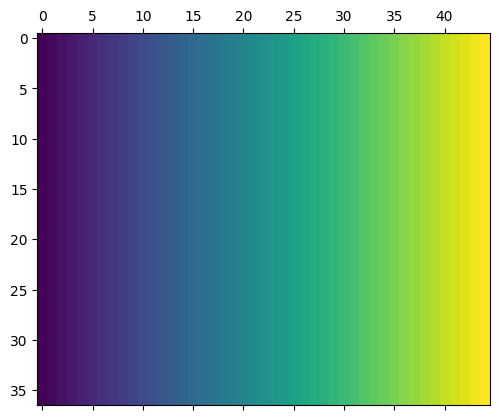

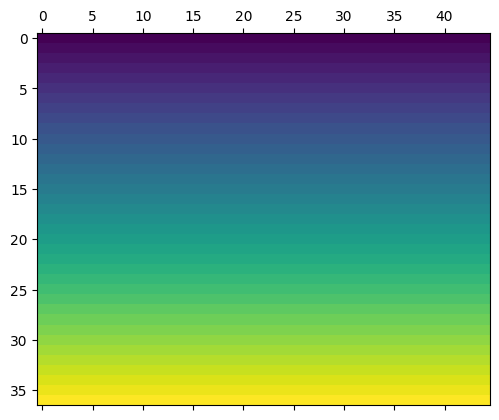

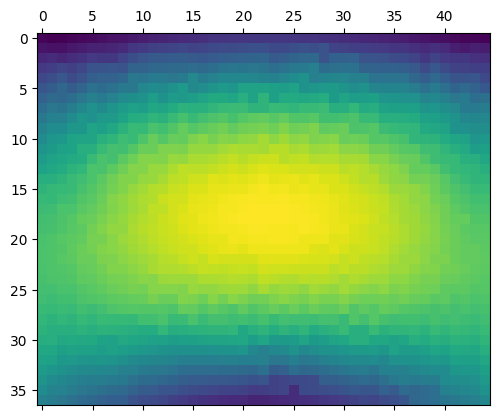

In [119]:
plt.matshow(X)
plt.matshow(Y)
plt.matshow(Z)

In [120]:
xrange = np.linspace(x_min, x_max, nx)
yrange = np.linspace(y_min, y_max, ny)
X,Y = np.meshgrid(xrange, yrange)
Z = np.empty(shape=(ny, nx))

H_a = np.empty(shape=(ny, nx))
K_a = np.empty(shape=(ny, nx))
P_absmax_a = np.empty(shape=(ny, nx))
# Curvedness
C_a = np.empty(shape=(ny, nx))

k1X = np.empty(shape=(ny, nx))
k1Y = np.empty(shape=(ny, nx))
k1Z = np.empty(shape=(ny, nx))
k2X = np.empty(shape=(ny, nx))
k2Y = np.empty(shape=(ny, nx))
k2Z = np.empty(shape=(ny, nx))

In [121]:
# Symbolic Explicit 2D mean/gaussian curvature
# H = mean_curvature_implicit(f, v)
# K = gaussian_curvature_implicit(f, v)

for i in range(len(xrange)):
    for j in range(len(yrange)):
        # Z[j, i] = f.subs({v[0]: xrange[i], v[1]: yrange[j]})

        # H_a[j, i] = H.subs({v[0]: x[i], v[1]: y[j]})
        # K_a[j, i] = K.subs({v[0]: x[i], v[1]: y[j]})

        point = [xrange[i],yrange[j]]
        # print(point, f.subs({v[0]: xrange[i], v[1]: yrange[j]}))
        K, H, k1, k2, k1vec, k2vec = surface_curvature.symbolic.curvature_explicit(f, (x,y), point)
        # print(K, H, k1, k2, k1vec, k2vec)

        P_absmax_a[j, i] = max([k1, k2], key=lambda x: abs(x))
        C_a[j, i] = sympy.sqrt((k1**2 + k2**2)/2)
        k1X[j, i] = k1vec[0] * k1
        k1Y[j, i] = k1vec[1] * k1
        k1Z[j, i] = k1vec[2] * k1
        k2X[j, i] = k2vec[0] * k2
        k2Y[j, i] = k2vec[1] * k2
        k2Z[j, i] = k2vec[2] * k2

In [122]:
## Finite curvature !! CURRENTLY NOT WORKING !!
# for i in range(len(xrange)):
#     for j in range(len(yrange)):
#         Z[j, i] = f.subs({v[0]: xrange[i], v[1]: yrange[j]})

# K, H, k1, k2, k1vec, k2vec = curvature_discrete_parametric(X,Y,Z)

# for i in range(len(xrange)):
#     for j in range(len(yrange)):
#         P_absmax_a[j, i] = max([k1[j,i], k2[j,i]], key=lambda x: abs(x))
#         C_a[j, i] = sympy.sqrt((k1[j,i]**2 + k2[j,i]**2)/2)
#         k1X[j, i] = k1vec[:,:,0][j,i] * k1[j,i]
#         k1Y[j, i] = k1vec[:,:,1][j,i] * k1[j,i]
#         k1Z[j, i] = k1vec[:,:,2][j,i] * k1[j,i]
#         k2X[j, i] = k2vec[:,:,0][j,i] * k2[j,i]
#         k2Y[j, i] = k2vec[:,:,1][j,i] * k2[j,i]
#         k2Z[j, i] = k2vec[:,:,2][j,i] * k2[j,i]

In [123]:
print(X.shape)
print(k1X.shape) #(37,45)=bad
print(C_a.shape)

(37, 45)
(37, 45)
(37, 45)


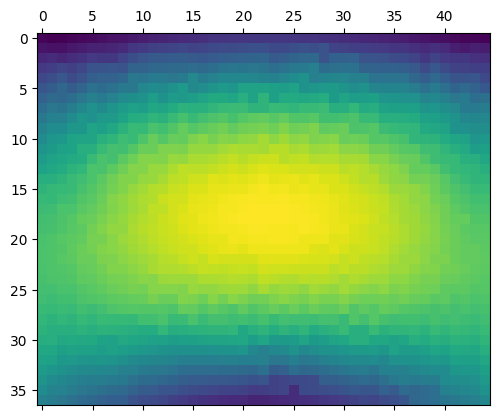

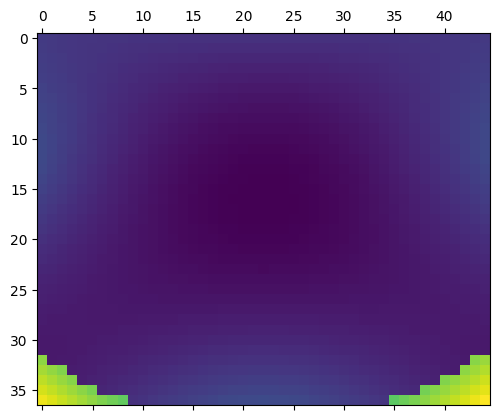

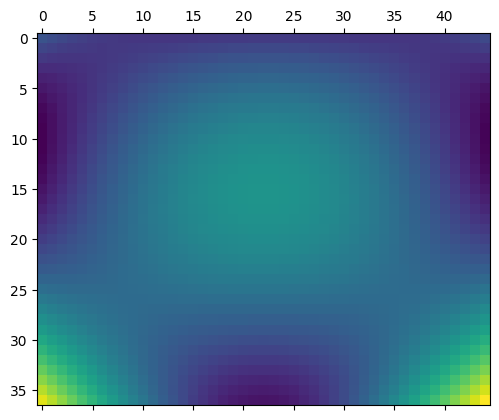

In [126]:
plt.matshow(Z)
# plt.matshow(H)
# plt.matshow(K)
plt.matshow(P_absmax_a)
plt.matshow(C_a)

In [127]:
print(f'{filename}')
print()
print('Prinicpal Curvature')
max_i,max_j = np.unravel_index(P_absmax_a.argmax(), P_absmax_a.shape)
min_i,min_j = np.unravel_index(P_absmax_a.argmin(), P_absmax_a.shape)
print(f'Min= {P_absmax_a.min()} rc={min_i,min_j} xy={min_j*resolution,min_i*resolution}')
print(f'Max= {P_absmax_a.max()} rc={max_i,max_j} xy={max_j*resolution,max_i*resolution}')
print(f'Avg= {P_absmax_a.mean()}')
print(f"Absolute maximum principal curvature: {max([P_absmax_a.max(), P_absmax_a.min()], key=lambda x: abs(x))}")
print()
print('Curvedness')
max_i,max_j = np.unravel_index(C_a.argmax(), C_a.shape)
min_i,min_j = np.unravel_index(C_a.argmin(), C_a.shape)
print(f'Min= {C_a.min()} rc={min_i,min_j} xy={min_j*resolution,min_i*resolution}')
print(f'Max= {C_a.max()} rc={max_i,max_j} xy={max_j*resolution,max_i*resolution}')
print(f'Avg= {C_a.mean()}')

C:\Users\a0487637\Documents\Projects\S800\MechanicalStress\python\20230413/S600_2p925mmCer_die_attach_deformation.txt

Prinicpal Curvature
Min= -0.00011122178692816166 rc=(16, 22) xy=(11.0, 8.0)
Max= 0.00014083523082123424 rc=(36, 44) xy=(22.0, 18.0)
Avg= -8.257792046634311e-05
Absolute maximum principal curvature: 0.00014083523082123424

Curvedness
Min= 4.041844746090512e-05 rc=(10, 0) xy=(0.0, 5.0)
Max= 0.00011936470262971582 rc=(36, 44) xy=(22.0, 18.0)
Avg= 6.637482631935242e-05


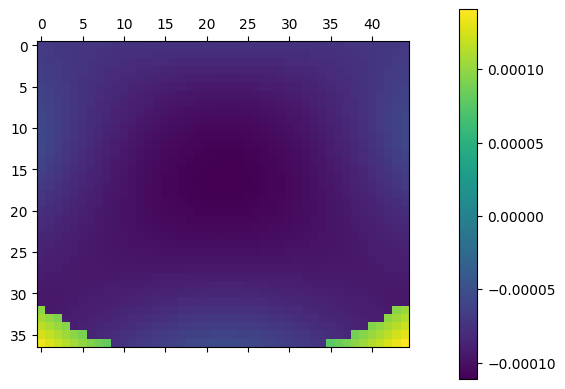

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)
pcm = ax.matshow(P_absmax_a) 
fig.colorbar(pcm, pad=0.1)

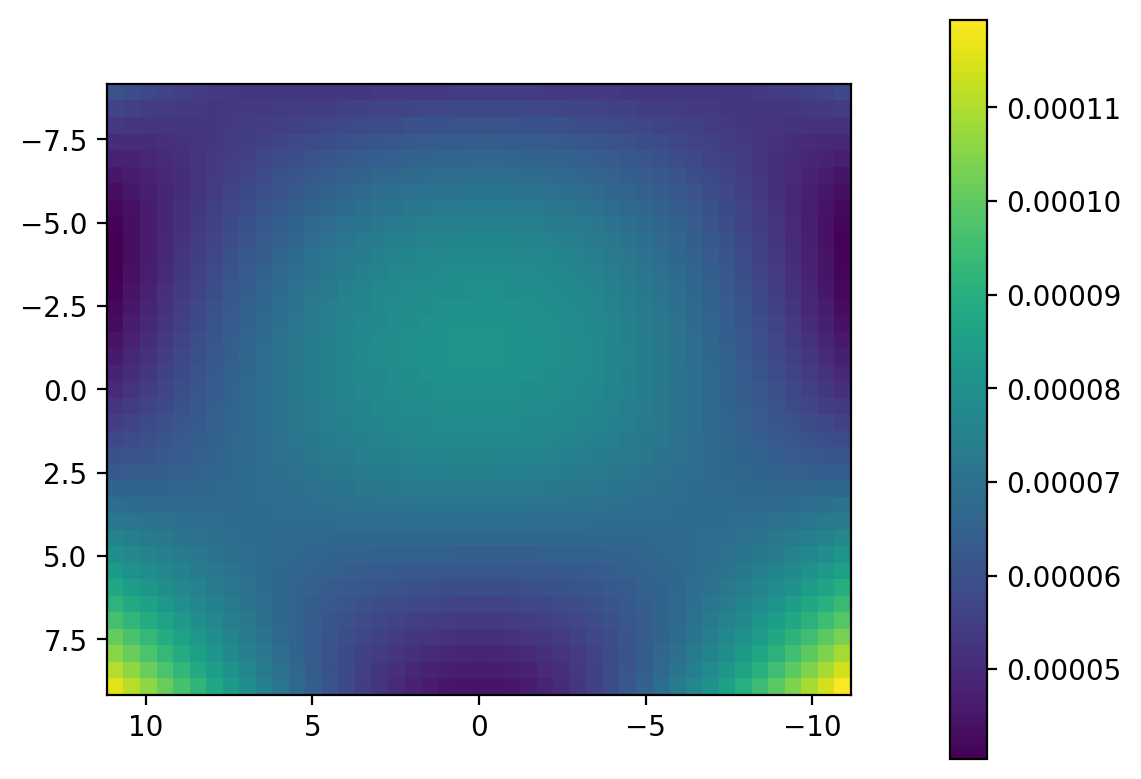

In [129]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
# ax.imshow(P_absmax_a, extent=[x_max, x_min, y_max, y_min])
pcm = ax.imshow(C_a, extent=[x_max, x_min, y_max, y_min])
# ax.imshow(Z, extent=[x_max, x_min, y_max, y_min])
# ax.quiver(X, Y, k1U, k1V,color='r',scale=0.003)
# ax.quiver(X, Y, k2U, k2V,color='g',scale=0.003)

fig.colorbar(pcm, pad=0.1)

In [130]:
fig = go.Figure(data=go.Heatmap(
          x = xrange,
          y = yrange,
          z = C_a,
          type = 'heatmap',
          colorscale = 'Viridis'))
fig.add_traces(ff.create_quiver(X, Y, k1X, k1Y, scale=3000, arrow_scale=0.5, line=dict(width=1, color='red')).data)
fig.add_traces(ff.create_quiver(X, Y, k2X, k2Y, scale=3000, arrow_scale=0.5,  line=dict(width=1, color='orange')).data)

fig.update_layout(title=f'{filename}\n curvedness along die attach', autosize=False, width=1000, height=1000, margin=dict(l=0, r=0, b=0), coloraxis_showscale=True)

fig.show()


Text(0, 0.5, 'Curvedess: C(x,y)')

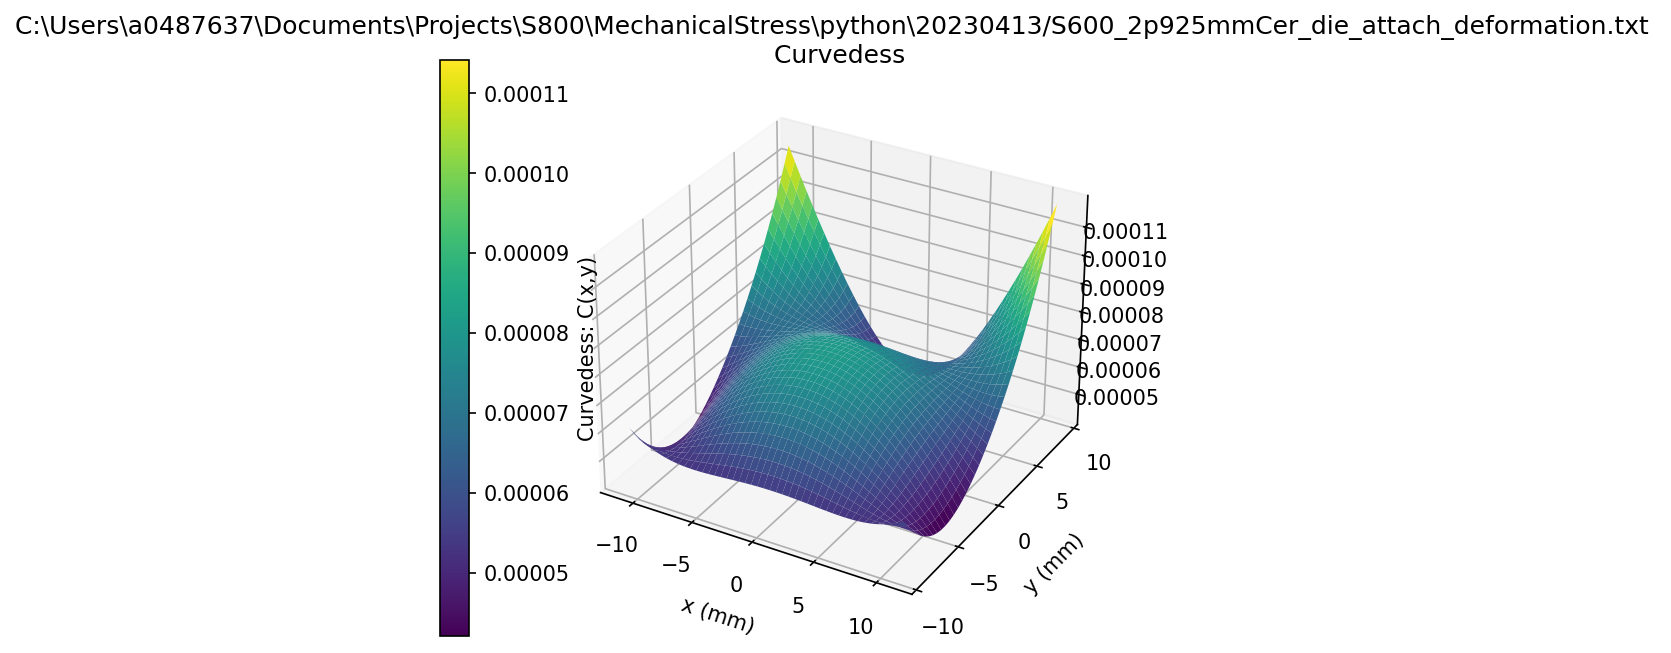

In [131]:
from matplotlib.colors import TwoSlopeNorm

X, Y = np.meshgrid(xrange, yrange)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n Curvedess')
asm = ax.plot_surface(X, Y, C_a, cmap='viridis') # cmap='viridis' / cmap='PiYG', norm=TwoSlopeNorm(vcenter=0) /  P_absmax_a / abs(P_absmax_a)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(asm, cax = cbaxes)
# plt.ylabel("Max Principal Curvature: k(x,y)")
plt.ylabel("Curvedess: C(x,y)")
# ax.quiver(X, Y, C_a, k1U, k1V, k1W,color='g', length=0.05)
# ax.view_init(30, -125)

In [132]:
fig = go.Figure(
    data=[
        go.Cone(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel()*100,
            u=k2X.ravel(), # YXZ
            v=k2Y.ravel(),
            w=k2Z.ravel()*100,
            sizemode="absolute",
            # sizeref=0.0005,
            anchor="tip",
            name="k2",
            hovertemplate="x: %{x}\ny: %{y}\nz: %{z}\n\nu: %{u}\nv: %{v}\nw: %{w}"
        ),
        go.Cone(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel()*100,
            u=k1X.ravel(),
            v=k1Y.ravel(),
            w=k1Z.ravel()*100,
            sizemode="absolute",
            # sizeref=0.0005,
            anchor="tip",
            name="k1",
            hovertemplate="x: %{x}\ny: %{y}\nz: %{z}\n\nu: %{u}\nv: %{v}\nw: %{w}"
        ),
    ]
)
fig.add_trace(go.Surface(x=X, y=Y, z=Z*100))
fig.show()